# Constantes
Ici on définit toutes les constantes et chemins utilisés dans le notebook.

In [ ]:
# Constantes globales pour la génération des spectrogrammes
SR = 44100
N_FFT = 2048
HOP_LENGTH = 512
N_MELS = 128
FIXED_DURATION = 2  # secondes
FIXED_LENGTH = SR * FIXED_DURATION

# Chemins (adaptés à ton Google Drive)
TRAIN_BASE_FOLDER = '/content/drive/MyDrive/dataset/full_training_set'
TEST_BASE_FOLDER = '/content/drive/MyDrive/dataset/testing_sets/test_salon'
TRAIN_OUTPUT_FOLDER = 'separated_channels'
TEST_OUTPUT_FOLDER = 'separated_channels_test'


# Fonctions

1. Fonctions utilitaires pour l'audio
Ces fonctions permettent de charger un fichier audio, calculer son spectrogramme Mel, séparer les canaux stéréo et convertir un spectrogramme en audio.

In [ ]:
import os
import numpy as np
import librosa
import soundfile as sf

def load_audio(file_path, sr=SR, fixed_length=FIXED_LENGTH):
    audio, _ = librosa.load(file_path, sr=sr)
    if len(audio) < fixed_length:
        audio = np.pad(audio, (0, fixed_length - len(audio)))
    else:
        audio = audio[:fixed_length]
    return audio

def compute_mel_spectrogram(audio, sr=SR, n_fft=N_FFT, hop_length=HOP_LENGTH, n_mels=N_MELS):
    mel_spec = librosa.feature.melspectrogram(
        y=audio,
        sr=sr,
        n_fft=n_fft,
        hop_length=hop_length,
        n_mels=n_mels
    )
    return librosa.power_to_db(mel_spec, ref=np.max)

def separate_channels(file_path, output_folder):
    """
    Charge un fichier stéréo, sépare les canaux gauche et droit et les sauvegarde.
    Retourne les chemins des fichiers générés.
    """
    audio, sr = librosa.load(file_path, sr=None, mono=False)
    left_channel = audio[0]
    right_channel = audio[1]
    base_name = os.path.splitext(os.path.basename(file_path))[0]
    left_file = os.path.join(output_folder, f"{base_name}_left.wav")
    right_file = os.path.join(output_folder, f"{base_name}_right.wav")
    sf.write(left_file, left_channel, sr)
    sf.write(right_file, right_channel, sr)
    return left_file, right_file

def spectrogram_to_audio(mel_spectrogram, sr=SR, n_fft=N_FFT, hop_length=HOP_LENGTH, n_mels=N_MELS):
    """
    Convertit un spectrogramme Mel (en dB) en audio à l'aide de l'algorithme Griffin-Lim.
    """
    mel_power = librosa.db_to_power(mel_spectrogram)
    stft = librosa.feature.inverse.mel_to_stft(mel_power, sr=sr, n_fft=n_fft)
    return librosa.griffinlim(stft, hop_length=hop_length, win_length=n_fft)

2. Fonctions de traitement des données
Ces fonctions permettent de mettre à jour le CSV avec les chemins des fichiers séparés, de créer un mapping du dataset, de prétraiter les données en calculant les spectrogrammes et de normaliser les données.


In [ ]:
import pandas as pd
import json
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

def update_csv_and_separate_channels(csv_file, base_folder, output_folder):
    """
    Charge le CSV, sépare les canaux des fichiers audio et met à jour le CSV avec les nouveaux chemins.
    Retourne le chemin du CSV mis à jour.
    """
    df = pd.read_csv(csv_file)
    os.makedirs(output_folder, exist_ok=True)
    df['Left_Channel'] = ''
    df['Right_Channel'] = ''

    for i, row in df.iterrows():
        file_name = row['filename']
        file_path = os.path.join(base_folder, file_name)
        if not file_name.endswith('.wav'):
            print(f"Skipping non-audio file: {file_name}")
            continue
        # Appel de la fonction de séparation
        left_file, right_file = separate_channels(file_path, output_folder)
        df.at[i, 'Left_Channel'] = left_file
        df.at[i, 'Right_Channel'] = right_file
        print(f"Saved: {left_file} et {right_file}")

    updated_csv = os.path.splitext(csv_file)[0] + "_updated.csv"
    df.to_csv(updated_csv, index=False)
    print(f"CSV mis à jour enregistré : {updated_csv}")
    return updated_csv

def create_dataset_mapping(csv_file, target_audio_dir):
    """
    Crée un mapping du dataset à partir du CSV et vérifie l'existence des fichiers.
    """
    df = pd.read_csv(csv_file)
    expected_columns = ['Left_Channel', 'Right_Channel', 'source_file']
    for col in expected_columns:
        if col not in df.columns:
            raise ValueError(f"Colonne manquante dans le CSV : {col}")

    dataset_mapping = []
    for _, row in df.iterrows():
        left_path = row['Left_Channel']
        right_path = row['Right_Channel']
        target_path = os.path.join(target_audio_dir, row['source_file'])

        if not os.path.exists(left_path) or not os.path.exists(right_path) or not os.path.exists(target_path):
            print(f"Fichier non trouvé pour {row['source_file']}")
            continue

        dataset_mapping.append({
            "left_channel": left_path,
            "right_channel": right_path,
            "target": target_path
        })
    return dataset_mapping

def save_dataset_mapping(mapping, output_json):
    with open(output_json, "w") as f:
        json.dump(mapping, f, indent=4)
    print(f"Mapping du dataset sauvegardé dans {output_json}")

def preprocess_data(csv_file_path, target_audio_dir):
    """
    Prépare les données en calculant les spectrogrammes pour chaque entrée.
    Retourne X_data (entrée stéréo) et Y_data (cible).
    """
    df = pd.read_csv(csv_file_path)
    X_data = []
    Y_data = []

    for index, row in df.iterrows():
        left_audio_path = row['Left_Channel']
        right_audio_path = row['Right_Channel']
        target_audio_path = os.path.join(target_audio_dir, row['source_file'])

        left_audio = load_audio(left_audio_path)
        right_audio = load_audio(right_audio_path)
        target_audio = load_audio(target_audio_path)

        left_spec = compute_mel_spectrogram(left_audio)
        right_spec = compute_mel_spectrogram(right_audio)
        target_spec = compute_mel_spectrogram(target_audio, hop_length=HOP_LENGTH)

        # Transposer pour avoir la forme (time_steps, mel_bins)
        left_spec = left_spec.T
        right_spec = right_spec.T
        target_spec = target_spec.T

        # Concaténer les canaux gauche et droit pour constituer l'entrée stéréo
        stereo_input = np.concatenate([left_spec, right_spec], axis=1)
        X_data.append(stereo_input)
        Y_data.append(target_spec)

    return np.array(X_data), np.array(Y_data)

def normalize_data(X_data, Y_data):
    """
    Normalise les données à l'aide d'un StandardScaler (ajusté sur l'ensemble des données).
    """
    X_reshaped = X_data.reshape(-1, X_data.shape[-1])
    Y_reshaped = Y_data.reshape(-1, Y_data.shape[-1])

    scaler_X = StandardScaler()
    scaler_Y = StandardScaler()

    X_norm = scaler_X.fit_transform(X_reshaped).reshape(X_data.shape)
    Y_norm = scaler_Y.fit_transform(Y_reshaped).reshape(Y_data.shape)

    return X_norm, Y_norm, scaler_X, scaler_Y

def normalize_data_test(X_test, Y_test, scaler_X, scaler_Y):
    # Transformer les données test avec les scalers déjà entraînés
    X_test_norm = scaler_X.transform(X_test.reshape(-1, X_test.shape[-1])).reshape(X_test.shape)
    Y_test_norm = scaler_Y.transform(Y_test.reshape(-1, Y_test.shape[-1])).reshape(Y_test.shape)
    return X_test_norm, Y_test_norm

def split_train_val(X, Y, test_size=0.2, random_state=42):
    return train_test_split(X, Y, test_size=test_size, random_state=random_state)

# Data processing
Dans cette section, on exécute les différentes étapes de traitement pour le training set (et on pourra faire de même pour le testing set).


In [ ]:
# --- Traitement pour le training set ---
# 1. Mise à jour du CSV avec séparation des canaux
csv_file_train = os.path.join(TRAIN_BASE_FOLDER, 'dataset_configurations.csv')
updated_csv_train = update_csv_and_separate_channels(csv_file_train, TRAIN_BASE_FOLDER, TRAIN_OUTPUT_FOLDER)

# 2. Création du mapping du dataset (assure-toi que la colonne 'source_file' existe dans le CSV)
target_audio_dir_train = os.path.join(TRAIN_BASE_FOLDER, 'target')
mapping = create_dataset_mapping(updated_csv_train, target_audio_dir_train)
save_dataset_mapping(mapping, "dataset_mapping.json")

# 3. Prétraitement des données : calcul des spectrogrammes pour constituer X (entrée stéréo) et Y (cible)
X_train, Y_train = preprocess_data(updated_csv_train, target_audio_dir_train)

# 4. Normalisation
X_train_norm, Y_train_norm, scaler_X, scaler_Y = normalize_data(X_train, Y_train)

# 5. Séparation en ensemble d'entraînement et de validation
X_train_final, X_val, Y_train_final, Y_val = split_train_val(X_train_norm, Y_train_norm)

print("Training data shapes :", X_train_final.shape, Y_train_final.shape)
print("Validation data shapes :", X_val.shape, Y_val.shape)

Saved: separated_channels/capture_001_left.wav et separated_channels/capture_001_right.wav
Saved: separated_channels/capture_002_left.wav et separated_channels/capture_002_right.wav
Saved: separated_channels/capture_003_left.wav et separated_channels/capture_003_right.wav
Saved: separated_channels/capture_004_left.wav et separated_channels/capture_004_right.wav
Saved: separated_channels/capture_005_left.wav et separated_channels/capture_005_right.wav
Saved: separated_channels/capture_006_left.wav et separated_channels/capture_006_right.wav
Saved: separated_channels/capture_007_left.wav et separated_channels/capture_007_right.wav
Saved: separated_channels/capture_008_left.wav et separated_channels/capture_008_right.wav
Saved: separated_channels/capture_009_left.wav et separated_channels/capture_009_right.wav
Saved: separated_channels/capture_010_left.wav et separated_channels/capture_010_right.wav
Saved: separated_channels/capture_011_left.wav et separated_channels/capture_011_right.wav

In [ ]:
# --- Pour le testing set ---
# La même logique peut être appliquée pour le testing set.
csv_file_test = os.path.join(TEST_BASE_FOLDER, 'dataset_configurations_test.csv')
updated_csv_test = update_csv_and_separate_channels(csv_file_test, TEST_BASE_FOLDER, TEST_OUTPUT_FOLDER)
target_audio_dir_test = os.path.join(TEST_BASE_FOLDER, 'target')
mapping_test = create_dataset_mapping(updated_csv_test, target_audio_dir_test)
save_dataset_mapping(mapping_test, "dataset_mapping_test.json")
X_test, Y_test = preprocess_data(updated_csv_test, target_audio_dir_test)
X_test_norm, Y_test_norm = normalize_data_test(X_test, Y_test, scaler_X, scaler_Y)

Saved: separated_channels_test/capture_001_left.wav et separated_channels_test/capture_001_right.wav
Saved: separated_channels_test/capture_002_left.wav et separated_channels_test/capture_002_right.wav
Saved: separated_channels_test/capture_003_left.wav et separated_channels_test/capture_003_right.wav
Saved: separated_channels_test/capture_004_left.wav et separated_channels_test/capture_004_right.wav
Saved: separated_channels_test/capture_005_left.wav et separated_channels_test/capture_005_right.wav
Saved: separated_channels_test/capture_006_left.wav et separated_channels_test/capture_006_right.wav
Saved: separated_channels_test/capture_007_left.wav et separated_channels_test/capture_007_right.wav
Saved: separated_channels_test/capture_008_left.wav et separated_channels_test/capture_008_right.wav
Saved: separated_channels_test/capture_009_left.wav et separated_channels_test/capture_009_right.wav
Saved: separated_channels_test/capture_010_left.wav et separated_channels_test/capture_010_

## Visualisation des données
Ici, on visualise quelques spectrogrammes et on reconstruit l'audio à partir de ces derniers pour vérifier que tout fonctionne correctement.

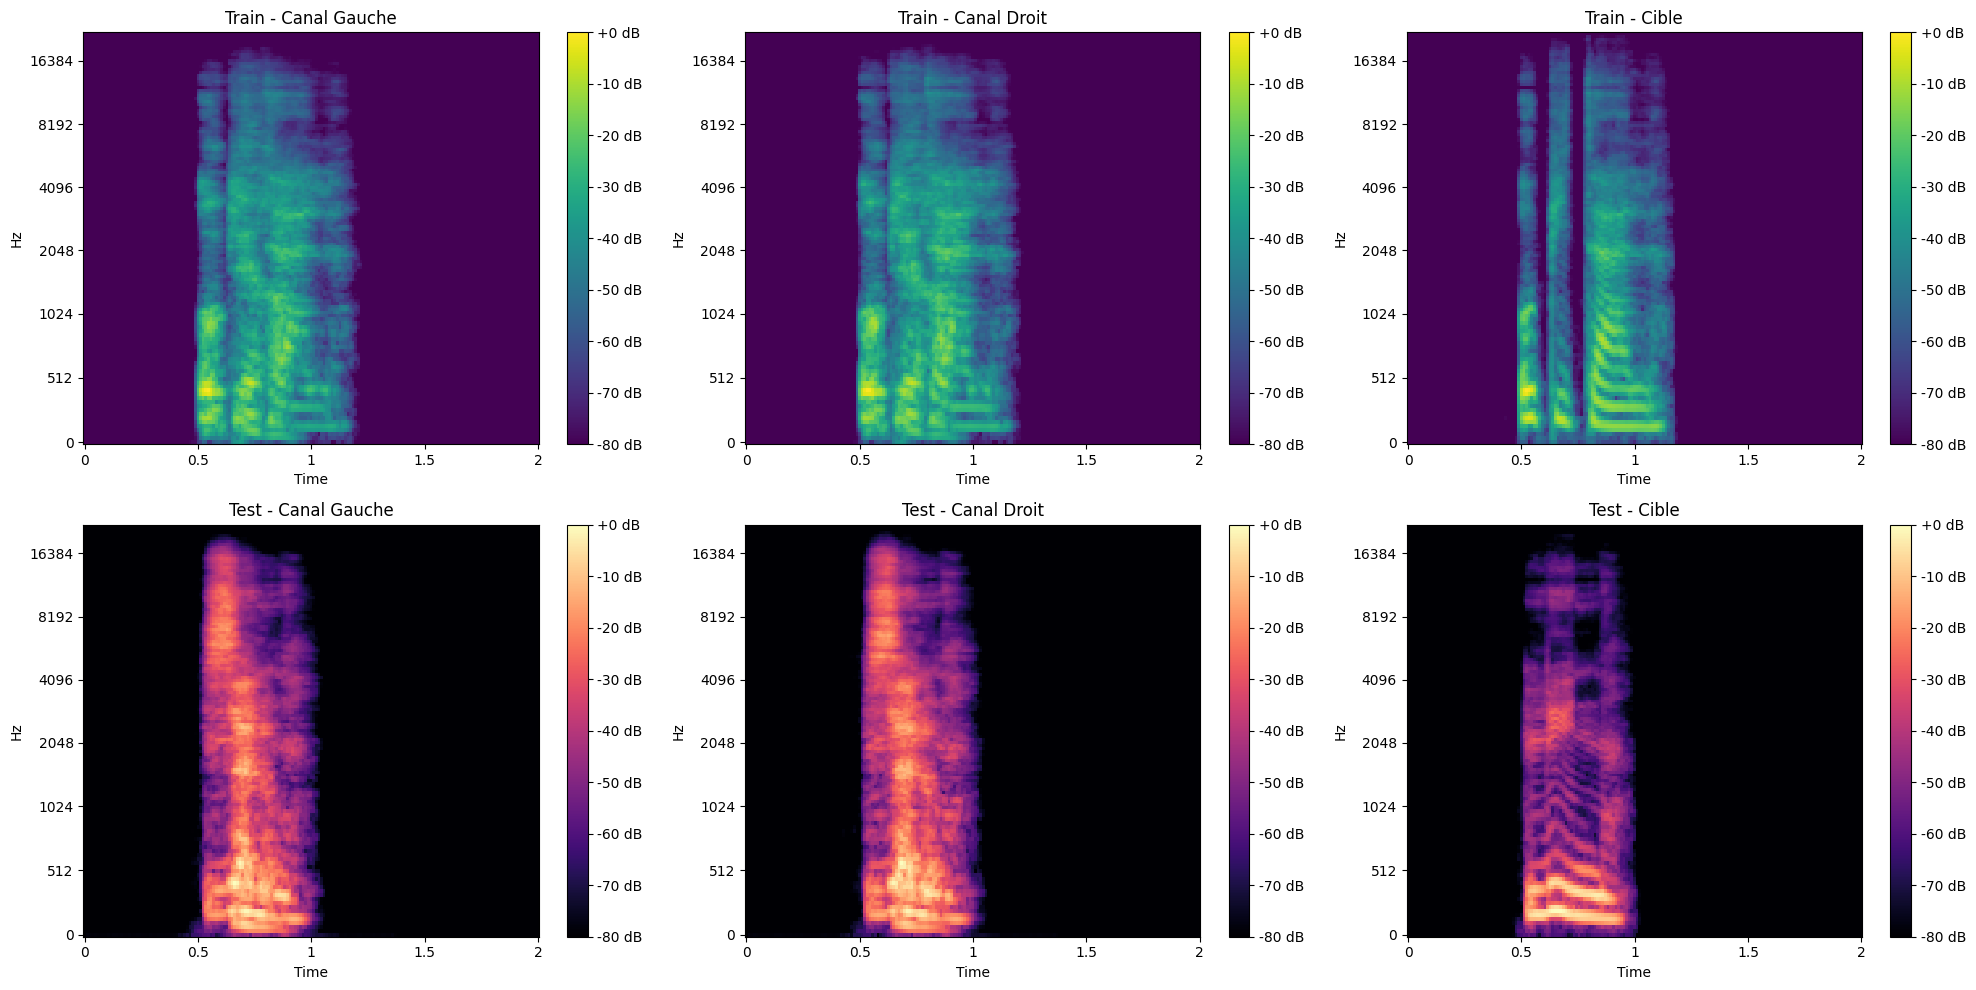

=== TRAINING SET ===
Canal Gauche (Training):


Canal Droit (Training):


Cible (Training):


=== TESTING SET ===
Canal Gauche (Test):


Canal Droit (Test):


Cible (Test):


In [ ]:
import matplotlib.pyplot as plt
import librosa.display
from IPython.display import Audio, display

# Sélection d'un échantillon pour visualisation (parmi le training et testing set)
sample_index = 0

# --- Training set ---
input_sample_train = X_train[sample_index]   # données brutes avant normalisation
true_output_train = Y_train[sample_index]

# Séparation des canaux pour le training set
left_sample_train = input_sample_train[:, :N_MELS]
right_sample_train = input_sample_train[:, N_MELS:]

# --- Testing set ---
input_sample_test = X_test[sample_index]     # données brutes du test
true_output_test = Y_test[sample_index]

# Séparation des canaux pour le testing set
left_sample_test = input_sample_test[:, :N_MELS]
right_sample_test = input_sample_test[:, N_MELS:]

# Affichage des spectrogrammes
plt.figure(figsize=(20, 10))

# Training set
plt.subplot(2, 3, 1)
plt.title('Train - Canal Gauche')
librosa.display.specshow(left_sample_train.T, sr=SR, hop_length=HOP_LENGTH, x_axis='time', y_axis='mel', cmap='viridis')
plt.colorbar(format='%+2.0f dB')

plt.subplot(2, 3, 2)
plt.title('Train - Canal Droit')
librosa.display.specshow(right_sample_train.T, sr=SR, hop_length=HOP_LENGTH, x_axis='time', y_axis='mel', cmap='viridis')
plt.colorbar(format='%+2.0f dB')

plt.subplot(2, 3, 3)
plt.title('Train - Cible')
librosa.display.specshow(true_output_train.T, sr=SR, hop_length=HOP_LENGTH, x_axis='time', y_axis='mel', cmap='viridis')
plt.colorbar(format='%+2.0f dB')

# Testing set
plt.subplot(2, 3, 4)
plt.title('Test - Canal Gauche')
librosa.display.specshow(left_sample_test.T, sr=SR, hop_length=HOP_LENGTH, x_axis='time', y_axis='mel', cmap='magma')
plt.colorbar(format='%+2.0f dB')

plt.subplot(2, 3, 5)
plt.title('Test - Canal Droit')
librosa.display.specshow(right_sample_test.T, sr=SR, hop_length=HOP_LENGTH, x_axis='time', y_axis='mel', cmap='magma')
plt.colorbar(format='%+2.0f dB')

plt.subplot(2, 3, 6)
plt.title('Test - Cible')
librosa.display.specshow(true_output_test.T, sr=SR, hop_length=HOP_LENGTH, x_axis='time', y_axis='mel', cmap='magma')
plt.colorbar(format='%+2.0f dB')

plt.tight_layout()
plt.show()

# Reconstruction audio pour chaque spectrogramme avec la fonction spectrogram_to_audio
# Pour le training set
left_audio_train  = spectrogram_to_audio(left_sample_train.T)
right_audio_train = spectrogram_to_audio(right_sample_train.T)
target_audio_train = spectrogram_to_audio(true_output_train.T)

# Pour le testing set
left_audio_test   = spectrogram_to_audio(left_sample_test.T)
right_audio_test  = spectrogram_to_audio(right_sample_test.T)
target_audio_test  = spectrogram_to_audio(true_output_test.T)

# Lecture audio
print("=== TRAINING SET ===")
print("Canal Gauche (Training):")
display(Audio(left_audio_train, rate=SR))
print("Canal Droit (Training):")
display(Audio(right_audio_train, rate=SR))
print("Cible (Training):")
display(Audio(target_audio_train, rate=SR))

print("=== TESTING SET ===")
print("Canal Gauche (Test):")
display(Audio(left_audio_test, rate=SR))
print("Canal Droit (Test):")
display(Audio(right_audio_test, rate=SR))
print("Cible (Test):")
display(Audio(target_audio_test, rate=SR))


# Modèle

## Définition du modèle

In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, TimeDistributed, Dropout

# Fonction pour construire le modèle LSTM
def build_lstm_model(input_shape, output_shape):
    model = Sequential()

    # LSTM layer 1
    model.add(LSTM(256, input_shape=input_shape, return_sequences=True))
    model.add(Dropout(0.2))  # Dropout pour régularisation

    # LSTM layer 2
    model.add(LSTM(128, return_sequences=True))
    model.add(Dropout(0.2))  # Dropout pour régularisation

    # TimeDistributed Dense layer pour faire correspondre l'output du LSTM à la forme de la cible
    model.add(TimeDistributed(Dense(output_shape[-1])))  # Output avec le même nombre de features que l'audio cible

    # Compiler le modèle avec optimiseur 'Adam'
    model.compile(optimizer='adam', loss='mean_squared_error')

    return model

# Construire le modèle
model = build_lstm_model(input_shape=(X_train_final.shape[1], X_train_final.shape[2]), output_shape=Y_train_final.shape)

# Vérifier l'architecture
model.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                          │ (None, 173, 256)            │         525,312 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 173, 256)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_1 (LSTM)                        │ (None, 173, 128)            │         197,120 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 173, 128)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ time_distributed (TimeDistributed)   │ (None, 173, 128)            │          16,512 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 738,944 (2.82 MB)

 Trainable params: 738,944 (2.82 MB)

 Non-trainable params: 0 (0.00 B)

## Entraînement du modèle

Epoch 1/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 33s 2s/step - loss: 0.8243 - val_loss: 0.3846
Epoch 2/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 17s 1s/step - loss: 0.3706 - val_loss: 0.2722
Epoch 3/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 17s 1s/step - loss: 0.2820 - val_loss: 0.2454
Epoch 4/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 17s 1s/step - loss: 0.2486 - val_loss: 0.2239
Epoch 5/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 20s 1s/step - loss: 0.2219 - val_loss: 0.2023
Epoch 6/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 21s 1s/step - loss: 0.1980 - val_loss: 0.2054
Epoch 7/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 20s 1s/step - loss: 0.2047 - val_loss: 0.1842
Epoch 8/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 22s 1s/step - loss: 0.1856 - val_loss: 0.1755
Epoch 9/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 16s 1s/step - loss: 0.1710 - val_loss: 0.1618
Epoch 10/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 20s 1s/step - loss: 0.1658 - val_loss: 0.1559
Epoch 11/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 21s 1s/step - loss: 0.1531 - val_loss: 0.1530
Epoch 12/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 19s 1s/step - loss: 0.1487 - val_lo

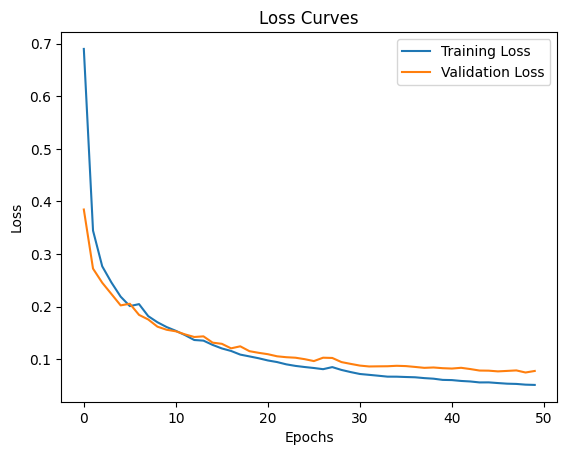

In [ ]:
import matplotlib.pyplot as plt

# entraîner le modèle
history = model.fit(
    X_train_final, Y_train_final,
    validation_data=(X_val, Y_val),
    epochs=50,  # à ajuster
    batch_size=32  # à ajuster
)

# afficher le graphique avec les erreurs au cours des epochs (training loss et validation loss)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss Curves')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

## Évaluation du modèle avec le dataset de test

Observation de la mse moyenne et l'écart-type sur tous les samples de test

In [ ]:
loss = model.evaluate(X_test_norm, Y_test_norm)
print(loss)

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 217ms/step - loss: 0.1915
0.19412429630756378


In [1]:
import numpy as np
from sklearn.metrics import mean_squared_error

# Prédictions du modèle
Y_pred = model.predict(X_test)

# Liste des MSE pour chaque sample (attention : dimensions à bien gérer selon la structure de Y)
mse_per_sample = []

for i in range(len(X_test)):
    # Flatten si nécessaire pour avoir des vecteurs
    y_true = Y_test[i].flatten()
    y_pred = Y_pred[i].flatten()

    mse = mean_squared_error(y_true, y_pred)
    mse_per_sample.append(mse)

# Convertir en array numpy pour statistiques
mse_per_sample = np.array(mse_per_sample)

# Moyenne et écart-type
mse_mean = np.mean(mse_per_sample)
mse_std = np.std(mse_per_sample)

print(f"MSE moyen : {mse_mean:.6f}")
print(f"Écart-type du MSE : {mse_std:.6f}")

NameError: name 'model' is not defined

Observation de l'erreur par frame pour les samples de test

In [2]:
import numpy as np
import matplotlib.pyplot as plt

Y_pred = model.predict(X_test)  # (batch_size, time_steps, features)
mse_per_sample_timestep = np.mean((Y_test - Y_pred)**2, axis=2)  # -> shape: (batch_size, time_steps)

# Tu peux faire ensuite :
mse_mean_per_condition = np.mean(mse_per_sample_timestep, axis=0)  # moyenne sur les samples, par timestep
mse_std_per_condition = np.std(mse_per_sample_timestep, axis=0)

plt.plot(mse_mean_per_condition, label='Moyenne MSE')
plt.fill_between(range(len(mse_mean_per_condition)),
                 mse_mean_per_condition - mse_std_per_condition,
                 mse_mean_per_condition + mse_std_per_condition,
                 alpha=0.3)
plt.title("Évolution temporelle du MSE")
plt.xlabel("Timestep")
plt.ylabel("MSE")
plt.legend()
plt.show()

NameError: name 'model' is not defined

## Visualisation des prédictions

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 234ms/step


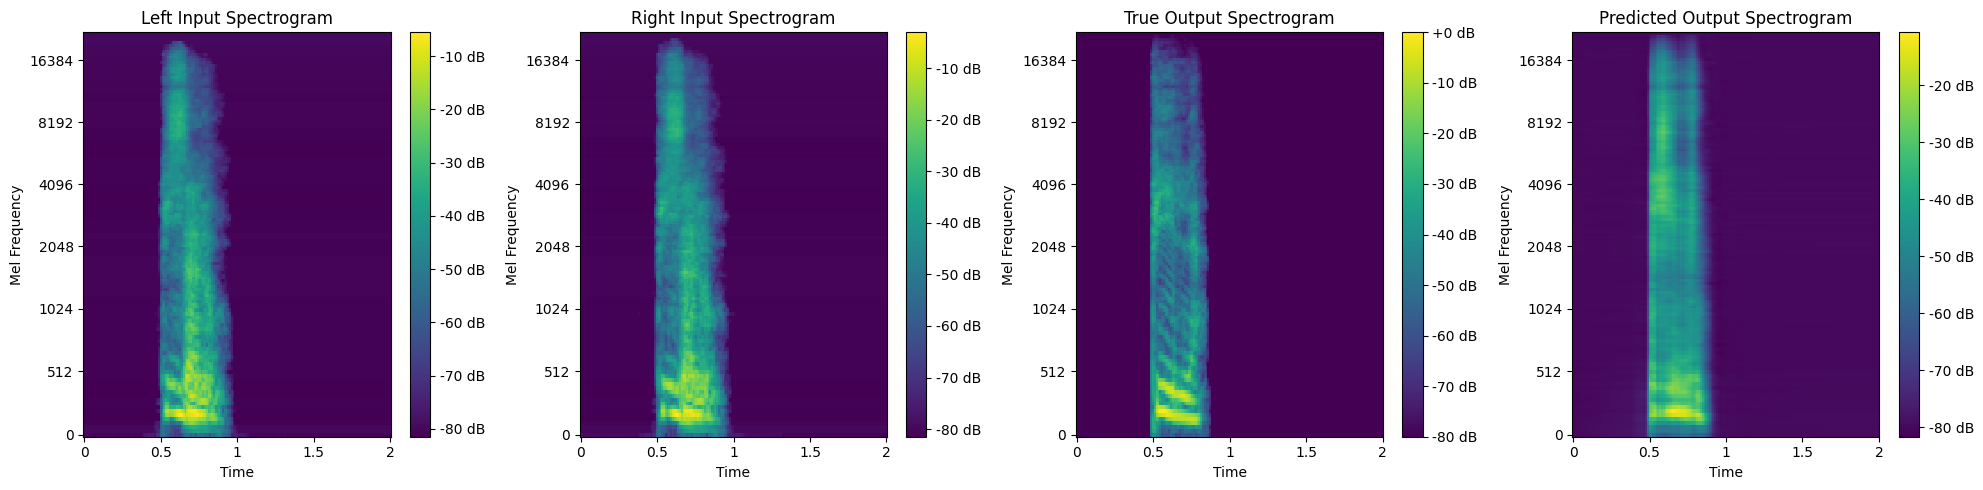

Mean Squared Error for sample 99: 18.982700
Playing Predicted Audio:


Playing True Audio:


Playing stereo Audio:


In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Aller chercher les prédictions du modèle (sur le dataset de validation)
predictions_test = model.predict(X_test_norm)

# Choisir un échantillon à visualiser (ici, le premier) et aller chercher toutes les data nécessaires
sample_index = 99
input_sample = X_test_norm[sample_index]
true_output = Y_test_norm[sample_index]
predicted_output = predictions_test[sample_index]
left_sample, right_sample = input_sample[:,:128], input_sample[:,128:]

# Inverser la normalisation & la transposition de la prédiction
# Retransformer en 2D pour inverser la transposition
predicted_output_2D = predicted_output.reshape(-1, predicted_output.shape[-1])
# Inverser la transfo
predicted_output_dB_2D = scaler_Y.inverse_transform(predicted_output_2D)
# Remettre en forme originale
predicted_output_dB = predicted_output_dB_2D.reshape(predicted_output.shape)
# Transposer en 2D à nouveau (n_mels, time_steps)
predicted_output_dB = predicted_output_dB.T

# Inverser la normalisation & la transposition de True Output
true_output_2D = true_output.reshape(-1, true_output.shape[-1])
true_output_dB_2D = scaler_Y.inverse_transform(true_output_2D)
true_output_dB = true_output_dB_2D.reshape(true_output.shape)
true_output_dB = true_output_dB.T

# Inverser la normalisation & la transposition de left_sample
left_sample_2D = left_sample.reshape(-1, left_sample.shape[-1])
left_sample_dB_2D = scaler_Y.inverse_transform(left_sample_2D)
left_sample_dB = left_sample_dB_2D.reshape(left_sample.shape)
left_sample_dB = left_sample_dB.T

# Inverser la normalisation & la transposition de right_sample
right_sample_2D = right_sample.reshape(-1, right_sample.shape[-1])
right_sample_dB_2D = scaler_Y.inverse_transform(right_sample_2D)
right_sample_dB = right_sample_dB_2D.reshape(right_sample.shape)
right_sample_dB = right_sample_dB.T

# Afficher les spectrogrammes (bcp de lignes surtout pour permettre un joli affichage)
plt.figure(figsize=(20, 5))

# Afficher le spectrogramme de l'audio gauche input
plt.subplot(1, 4, 1)
plt.title('Left Input Spectrogram')
librosa.display.specshow(left_sample_dB, sr=SR, hop_length=HOP_LENGTH, x_axis='time', y_axis='mel', cmap='viridis')
plt.colorbar(format='%+2.0f dB')
plt.xlabel('Time')
plt.ylabel('Mel Frequency')

# Afficher le spectrogramme de l'audio droit input
plt.subplot(1, 4, 2)
plt.title('Right Input Spectrogram')
librosa.display.specshow(right_sample_dB, sr=SR, hop_length=HOP_LENGTH, x_axis='time', y_axis='mel', cmap='viridis')
plt.colorbar(format='%+2.0f dB')
plt.xlabel('Time')
plt.ylabel('Mel Frequency')

# Afficher le spectrogramme de la cible
plt.subplot(1, 4, 3)
plt.title('True Output Spectrogram')
librosa.display.specshow(true_output_dB, sr=SR, hop_length=HOP_LENGTH, x_axis='time', y_axis='mel', cmap='viridis')
plt.colorbar(format='%+2.0f dB')
plt.xlabel('Time')
plt.ylabel('Mel Frequency')

# Afficher le spectrogramme de la prédiction
plt.subplot(1, 4, 4)
plt.title('Predicted Output Spectrogram')
librosa.display.specshow(predicted_output_dB, sr=SR, hop_length=HOP_LENGTH, x_axis='time', y_axis='mel', cmap='viridis')
plt.colorbar(format='%+2.0f dB')
plt.xlabel('Time')
plt.ylabel('Mel Frequency')

plt.tight_layout()
plt.show()

# En option : afficher l'erreur associée à cet échantillon
mse = np.mean((predicted_output_dB - true_output_dB) ** 2)
print(f"Mean Squared Error for sample {sample_index}: {mse:.6f}")

#########################
## Conversion en audio ##
#########################
import librosa
import librosa.display
import numpy as np
import soundfile as sf
from IPython.display import Audio

def spectrogram_to_audio(mel_spectrogram_dB, sr=44100, n_fft=2048, hop_length=512, n_mels=128):
    """
    Convert a mel-spectrogram back to audio using Griffin-Lim algorithm.

    Parameters:
        mel_spectrogram_dB (np.ndarray): Input mel-spectrogram (in dB).
        sr (int): Sampling rate.
        n_fft (int): FFT window size.
        hop_length (int): Hop length for STFT.
        n_mels (int): Number of mel bins.

    Returns:
        np.ndarray: Reconstructed audio signal.
    """
    # Conversion en puissance dB (fonction inverse à librosa.power_to_db)
    mel_spectrogram_power = librosa.db_to_power(mel_spectrogram_dB, ref=1.0)

    # Inverser le mel-spectrogramme en spectrogramme linéaire
    linear_spectrogram = librosa.feature.inverse.mel_to_stft(
        mel_spectrogram_power,
        sr=sr,
        n_fft=n_fft,
        power=1.0
    )

    # Reconstruction de l'audio en utilisant Griffin-Lim
    audio = librosa.griffinlim(
        linear_spectrogram,
        n_iter=32,  # Nombre d'itérations pour Griffin-Lim
        hop_length=hop_length,
        win_length=n_fft
    )
    return audio

# Conversion du spectrogramme prédit en audio
predicted_audio = spectrogram_to_audio(predicted_output_dB)

# Conversion du vrai spectrogramme cible en audio
true_audio = spectrogram_to_audio(true_output_dB)

# Conversion des input du modèle (gauche et droit) en audio
left_audio = spectrogram_to_audio(left_sample_dB)
right_audio = spectrogram_to_audio(right_sample_dB)

stereo_audio = np.vstack((left_audio, right_audio))

# Possibilité de les télécharger
#sf.write('predicted_audio.wav', predicted_audio, samplerate=44100)
#sf.write('true_audio.wav', true_audio, samplerate=44100)

# Les jouer dans colab
print("Playing Predicted Audio:")
display(Audio(predicted_audio, rate=44100))

print("Playing True Audio:")
display(Audio(true_audio, rate=44100))

print("Playing stereo Audio:")
display(Audio(stereo_audio, rate=44100))

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import librosa.display
from IPython.display import Audio, display

def inverse_normalization(spectrogram, scaler):
    """
    Inverse la normalisation appliquée à un spectrogramme et retourne le résultat transposé
    pour obtenir une forme (n_mels, time_steps) compatible avec librosa.display.
    """
    # Transformer en 2D pour inverser la normalisation
    spectrogram_2D = spectrogram.reshape(-1, spectrogram.shape[-1])
    inv_spec_2D = scaler.inverse_transform(spectrogram_2D)
    # Remettre en forme d'origine
    inv_spec = inv_spec_2D.reshape(spectrogram.shape)
    return inv_spec.T

def visualize_predictions(dataset_name, X_norm, Y_norm, predictions, scaler, sample_index):
    """
    Affiche les spectrogrammes d'entrée (canaux gauche et droit), la vraie sortie et la prédiction pour un échantillon,
    calcule l'erreur et reconstruit l'audio pour écoute.

    Paramètres :
        dataset_name (str) : Nom du dataset (ex: "Training" ou "Test")
        X_norm (np.ndarray) : Données d'entrée normalisées (stéréo concaténées)
        Y_norm (np.ndarray) : Cibles normalisées
        predictions (np.ndarray) : Prédictions du modèle
        scaler : Scaler (ex : scaler_Y) utilisé pour inverser la normalisation
        sample_index (int) : Index de l'échantillon à visualiser
    """
    # Récupération de l'échantillon
    input_sample = X_norm[sample_index]
    true_output = Y_norm[sample_index]
    predicted_output = predictions[sample_index]

    # Séparation des canaux (on suppose que chaque canal possède N_MELS colonnes)
    left_sample  = input_sample[:, :N_MELS]
    right_sample = input_sample[:, N_MELS:]

    # Inverser la normalisation pour chaque composante
    left_sample_dB    = inverse_normalization(left_sample, scaler)
    right_sample_dB   = inverse_normalization(right_sample, scaler)
    true_output_dB    = inverse_normalization(true_output, scaler)
    predicted_output_dB = inverse_normalization(predicted_output, scaler)

    # Visualisation des spectrogrammes
    plt.figure(figsize=(20, 5))

    plt.subplot(1, 4, 1)
    plt.title(f'{dataset_name} - Left Input Spectrogram')
    librosa.display.specshow(left_sample_dB, sr=SR, hop_length=HOP_LENGTH, x_axis='time', y_axis='mel', cmap='viridis')
    plt.colorbar(format='%+2.0f dB')
    plt.xlabel('Time')
    plt.ylabel('Mel Frequency')

    plt.subplot(1, 4, 2)
    plt.title(f'{dataset_name} - Right Input Spectrogram')
    librosa.display.specshow(right_sample_dB, sr=SR, hop_length=HOP_LENGTH, x_axis='time', y_axis='mel', cmap='viridis')
    plt.colorbar(format='%+2.0f dB')
    plt.xlabel('Time')
    plt.ylabel('Mel Frequency')

    plt.subplot(1, 4, 3)
    plt.title(f'{dataset_name} - True Output Spectrogram')
    librosa.display.specshow(true_output_dB, sr=SR, hop_length=HOP_LENGTH, x_axis='time', y_axis='mel', cmap='viridis')
    plt.colorbar(format='%+2.0f dB')
    plt.xlabel('Time')
    plt.ylabel('Mel Frequency')

    plt.subplot(1, 4, 4)
    plt.title(f'{dataset_name} - Predicted Output Spectrogram')
    librosa.display.specshow(predicted_output_dB, sr=SR, hop_length=HOP_LENGTH, x_axis='time', y_axis='mel', cmap='viridis')
    plt.colorbar(format='%+2.0f dB')
    plt.xlabel('Time')
    plt.ylabel('Mel Frequency')

    plt.tight_layout()
    plt.show()

    # Calcul de l'erreur (MSE) pour cet échantillon
    mse = np.mean((predicted_output_dB - true_output_dB) ** 2)
    print(f"Mean Squared Error for sample {sample_index} ({dataset_name}): {mse:.6f}")

    ####################################
    ## Conversion des Spectrogrammes en Audio ##
    ####################################
    # On suppose que la fonction spectrogram_to_audio est déjà définie
    predicted_audio = spectrogram_to_audio(predicted_output_dB)
    true_audio      = spectrogram_to_audio(true_output_dB)
    left_audio      = spectrogram_to_audio(left_sample_dB)
    right_audio     = spectrogram_to_audio(right_sample_dB)

    # Reconstitution de l'audio stéréo à partir des inputs
    stereo_audio = np.vstack((left_audio, right_audio))

    # Lecture audio
    print(f"Playing Predicted Audio ({dataset_name}):")
    display(Audio(predicted_audio, rate=SR))

    print(f"Playing True Audio ({dataset_name}):")
    display(Audio(true_audio, rate=SR))

    print(f"Playing Stereo Audio (Input) ({dataset_name}):")
    display(Audio(stereo_audio, rate=SR))

# Exemple d'utilisation pour le jeu de validation (training set)
# -------------------------------------------------------------
# On suppose que pour le jeu de validation, les données normalisées sont X_val et Y_val,
# et que les prédictions ont été obtenues via : predictions = model.predict(X_val)
visualize_predictions("Training", X_val, Y_val, predictions, scaler_Y, sample_index=50)

# Exemple d'utilisation pour le jeu de test
# -------------------------------------------------------------
# On suppose que pour le jeu de test, les données normalisées sont X_test_normalized et Y_test_normalized,
# et que les prédictions ont été obtenues via : predictions_test = model.predict(X_test_normalized)
visualize_predictions("Test", X_test_normalized, Y_test_normalized, predictions_test, scaler_Y, sample_index=50)


NameError: name 'predictions' is not defined